## `by S.Midianko`
### Part III.
This notebook covers: 
- Transforming data to be PyStan compatible;
- Defining the model mathematically;
- Setting up the model in pyStan; 
- Generating posterior samples & drawing vizualizations;
- Answering required questions;
- _Side note: check notebooks Part I and II for cleaning, pre-processing, and handling missing values algorithm._
---
[assignment instr](https://course-resources.minerva.kgi.edu/uploaded_files/mke/00194886-5832/cs146-lba.pdf) | [report link](https://docs.google.com/document/d/1KA-QCPKiDgcmLJbf6eTsGDG6yRznDQlPz9q71awVgn8/edit) | [data link](https://docs.google.com/spreadsheets/d/1OTkoj5QrKkq8DMjd82Rc1dERBn1Fkwusf01GKNqALoM/edit)
---- 

## 0. Importing libraries and defining some useful dictionaries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import scipy.stats as sts
import random

In [ ]:
df = pd.read_csv('FINAL DATASET.csv')

In [ ]:
# this dictionary will be useful in multiple occasions below. 
products_dict = {'apple1-quantity-kg': 'apple1-price',\
                        'apple2-quantity-kg': 'apple2-price',\
                        'apple3-quantity-kg':'apple3-price',\
                     
                         'banana1-quantity-kg':'banana1-price',\
                       'banana2-quantity-kg':'banana2-price',\
                       'banana3-quantity-kg':'banana3-price',\
                        
                      'tomato1-quantity-kg' :'tomato1-price',\
                      'tomato2-quantity-kg':'tomato2-price',\
                      'tomato3-quantity-kg':'tomato3-price',\
                        
                      'potato1-quantity-kg': 'potato1-price',\
                      'potato2-quantity-kg': 'potato2-price',\
                        'potato3-quantity-kg': 'potato3-price',\
                        
                      'flour1-quantity-kg': 'flour1-price',\
                       'flour2-quantity-kg': 'flour2-price',\
                       'flour3-quantity-kg': 'flour3-price',\
                        
                       'rice1-quantity-kg': 'rice1-price',\
                       'rice2-quantity-kg': 'rice2-price',\
                       'rice3-quantity-kg': 'rice3-price',\
                        
                       'milk1-quantity-l':'milk1-price',\
                       'milk2-quantity-l':'milk2-price',\
                       'milk3-quantity-l':'milk3-price',\
                        
                        'butter1-quantity-kg': 'butter1-price',\
                        'butter2-quantity-kg': 'butter2-price',\
                        'butter3-quantity-kg': 'butter3-price',\
                        
                       'egg1-quantity-count':'egg1-price',\
                       'egg2-quantity-count':'egg2-price',\
                       'egg3-quantity-count':'egg3-price',\
                        
                        'chicken1-quantity-kg':'chicken1-price',\
                        'chicken2-quantity-kg':'chicken2-price',\
                        'chicken3-quantity-kg':'chicken3-price'}

all_countries = df["country"].unique()

## 1. Final pre-processing: making the data PyStan compatible.

In [ ]:
'''We will have to drop two stores located in SF as these are duplicates.
These are with indices 53 and 46. We will only keep one of Trader Joe stores (4th street), 
data for which was collected by Daniel H..'''
#df.loc[53,:]
#df.loc[46,:]
df = df.drop([53, 46])
df.shape

(62, 69)

In [ ]:
'''Further, we can delete quantity now since the values have been normalized in the notebook Part II.'''
quantaties_cols_lst = list(products_dict.keys())
df = df.drop(labels = quantaties_cols_lst, axis = 1)
df = df.drop(["Unnamed: 0", 'email'], axis = 1) # dropping unnecessary columns as well
df.shape

(62, 37)

#### Transforming each mentioned price to a single currency (USD).

In [ ]:
'''multiplying each price in the columns by the exchange rate (home_currency -> USD).
The conversion rates are already specified in _to_usd_rate_ column. 
''' 
all_prices_columns = list(products_dict.values()) 
for idx, row in df.iterrows(): 
    for each_col in all_prices_columns: 
        new_val = df.at[idx, each_col] * df.at[idx, 'to_usd_rate']
        df.at[idx, each_col] = new_val

    new_val = float(df.at[idx, 'ave_rental_price_m2'])* df.at[idx, 'to_usd_rate']
    df.at[idx, 'ave_rental_price_m2'] = new_val

In [ ]:
# and now dropping more unnecessary columns
df = df.drop(labels =['currency', 'to_usd_rate', 'ave-rental-price'], axis = 1)
df.head(3)

,country,grocery-store,price-perception,apple1-price,apple2-price,apple3-price,banana1-price,banana2-price,banana3-price,tomato1-price,...,butter1-price,butter2-price,butter3-price,egg1-price,egg2-price,egg3-price,chicken1-price,chicken2-price,chicken3-price,ave_rental_price_m2
0,Germany,"EDEKA, Grunerstraße 20",Mid-range,3.4867,1.9159,2.082500,2.0587,2.0587,1.7374,5.80125,...,10.2340,10.1864,9.9960,0.751683,0.347083,0.592025,15.141987,7.675500,8.627500,15.30
1,Germany,"EDEKA Andreasstraße 59, 10243 Berlin",Mid-range,2.3205,3.4867,4.358375,2.0587,1.3209,2.0587,3.37960,...,8.5680,10.9956,7.4256,0.581117,0.541450,0.193970,15.161929,19.842558,34.896463,14.45
2,Germany,"EDEKA BAUR, Gottlieber Str. 34, 78462 Konstanz",Mid-range,3.4867,1.4875,2.034900,2.7965,1.7374,1.7374,2.28480,...,13.1376,6.4736,13.9468,0.290360,0.384370,0.148750,7.695333,8.657250,11.424000,17.00


#### We will need to further transform our data to ensure that it is compatible with PyStan setup.

In [ ]:
# defining unique lists for: 
products = ['apple', 'banana', 'tomatoes', 'potatoes','flour', 'rice', 'milk',  'butter','egg', 'chicken']
all_countries = df["country"].unique()
store_types = df['price-perception'].unique()

In [ ]:
'''To better work with Pystan, we will utillze indices rather than string values. 
Our final goal is to create a df with ['product', 'price', 'store-type', 'country'] as columns. 
For this, we will create mapping dataframes for each of the category mentioned above, but price.'''
# dataframe for country & their indices
country_df= pd.DataFrame({'country': all_countries})
country_df['ID'] = np.arange(start = 1, stop = len(all_countries)+1 )
country_df.head(3)

,country,ID
0,Germany,1
1,Guatemala,2
2,Morocco,3


In [ ]:
# dataframe for store_type & their indices
store_df= pd.DataFrame({'store-type': store_types})
store_df['ID'] = np.arange(start = 1, stop = len(store_types)+1 )
store_df.head(3)

,store-type,ID
0,Mid-range,1
1,Luxury (expensive),2
2,Budget (cheap),3


In [ ]:
# dataframe for product & their indices
column_to_append = []
val_before = 0
for value in range(3, len(all_prices_columns)+1, 3): 

    column_to_append.append(all_prices_columns[val_before: value])
    val_before = value
    
product_df= pd.DataFrame({'product':products})
product_df['ID'] = np.arange(start = 1, stop = len(products)+1)
product_df['corresponding-products'] = column_to_append
product_df.head(3)

,product,ID,corresponding-products
0,apple,1,"[apple1-price, apple2-price, apple3-price]"
1,banana,2,"[banana1-price, banana2-price, banana3-price]"
2,tomatoes,3,"[tomato1-price, tomato2-price, tomato3-price]"


In [ ]:
# first creating an empty df. will fill in below. 
pyStan_data = pd.DataFrame(columns=['product', 'price', 'store-type', 'country'])

In [ ]:
''''iterating over our big dataframe.
for each row in df, we will look up what products are in a row
and what is their country + store-type
and basically 'reconstruct' the df to look the way we want (as defined above)
'''
num_rows = df.shape[0]
for idx, row in df.iterrows():
    for each_col in all_prices_columns: 
        PRODUCT = each_col
        PRICE = df.at[idx, each_col]
        STORE_TYPE = df.at[idx, 'price-perception']
        COUNTRY = df.at[idx, 'country']
        
        pyStan_data = pyStan_data.append({'product':PRODUCT,
                            'price': PRICE,
                            'store-type': STORE_TYPE,
                            'country':COUNTRY
                           }, ignore_index = True)

In [ ]:
pyStan_data.head(4)

,product,price,store-type,country
0,apple1-price,3.4867,Mid-range,Germany
1,apple2-price,1.9159,Mid-range,Germany
2,apple3-price,2.0825,Mid-range,Germany
3,banana1-price,2.0587,Mid-range,Germany


In [ ]:
'''as I mentioned above, we want to work with indices, rather than string values. 
we now will do matching for each of the value in the row
and instead of having specific product specified, we will
replace it with the id (which are defined in corresponsing df)'''
for idx, row in pyStan_data.iterrows(): 
    
    product_to_match = pyStan_data.at[idx, 'product']
    for count, sublist in enumerate(list(product_df["corresponding-products"])): 
        if product_to_match in sublist: 
            pyStan_data.at[idx, 'product'] = count+1
            
    store_type_to_match = pyStan_data.at[idx, 'store-type']
    for count, elem in enumerate(list(store_df["store-type"])): 
        if elem == store_type_to_match: 
            pyStan_data.at[idx, 'store-type'] = count+1
            
    country_to_match = pyStan_data.at[idx, 'country']
    for count, elem in enumerate(list(country_df["country"])): 
        if elem == country_to_match: 
            pyStan_data.at[idx, 'country'] = count+1

In [ ]:
pyStan_data.head(4)

,product,price,store-type,country
0,1,3.4867,1,1
1,1,1.9159,1,1
2,1,2.0825,1,1
3,2,2.0587,1,1


In [ ]:
print('Shape of the data before dropping NAs is: ', pyStan_data.shape)
print(f'There are {pyStan_data.shape[0]-pyStan_data.dropna().shape[0]} NA values')
pyStan_data = pyStan_data.dropna()
print('Shape of the data before dropping NAs is: ', pyStan_data.shape)

Shape of the data before dropping NAs is:  (1860, 4)
There are 13 NA values
Shape of the data before dropping NAs is:  (1847, 4)


## 2. Setting up the model.

#### Prior: the base price of each product
- First, let me describe the information I know regarding the base price: 
- Price is a positive real number (support $>0$). 
-  Generally, I have no clue for what prices might be. I only know approximate prices for London, maybe, and it is very limited. 
- Considering this limited knowledge, I should pick some broad prior. 
- Therefore, we should have heavy-tailed distributions, such as $Student-T$, $Cauchy$ or $Log-normal$.
- $Cauchy$ (which also does not have theoretical moments) is often used for uncertain priors, so I choose to go with it. 
- The only two parameters are mode location (which specifies the peak of distribution) and scale (which specifies the half-width at half-maximum of the distribution).
- I will use the following hyperparameters: $loc = 0$ and $\gamma = 10$. This is because I do know that products should not be super expensive (e.g. more than 200 and will likely to be centered near 0 because of the small units. 
- All in all the choice of this prior is fully based on my prior knowledge.
$$Cauchy(P_{i}|0, 10)$$


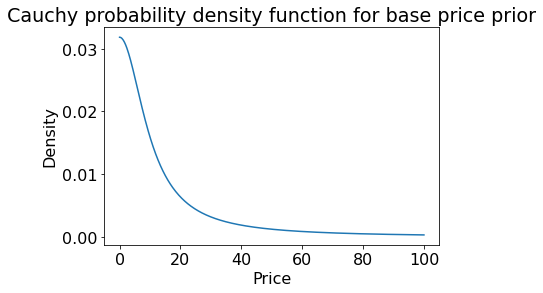

In [ ]:
# Cauchy prior
basep_prior = sts.cauchy(0, 10)
x = np.linspace(0,100, 500)
plt.plot(x, basep_prior.pdf(x))
plt.title("Cauchy probability density function for base price prior")
plt.ylabel('Density')
plt.xlabel('Price')
plt.show()

#### Prior: The multiplier for each store type (budget/mid-range/luxury).
- Again, I outline my reasoning and available information below.
- Multiplier a scale parameter (positive real number, support $>0$).
- The prior should be centered on $1$, to achieve an average multiplier of $1$. This would make the base price (approximately) match the average price in mid-range stores.
- Since $Log-normal$ has multiplicative effect (similar to multiplier) and continuous positive support, we will proceed with this. 
I choose such hyperparameters so that the mean is equal to $0$. These will be: $\mu =0$ and $\sigma = 0.2$.
    $$Lognormal(M_{s_j}| 0, 0.2)$$
   where $M_{s_j}$ is a store multiplier for store $j$.


In [ ]:
# from documentation: 
#"A common parametrization for a lognormal random variable Y is in terms of the mean, mu, 
#and standard deviation, sigma, of the unique normally distributed random variable X such that exp(X) = Y. 
#This parametrization corresponds to setting s = sigma and scale = exp(mu).""
store_prior = sts.lognorm(s=0.2, scale=np.exp(0))
store_prior.mean() # just double checking is mean is 1

1.0202013400267558

#### Prior: The multiplier for the country or state.
- This is the scale parameter (positive real number).
- The prior should also be centered on 1 for similar reason as for $M_{s_j}$.
- It also has a multiplicative effect. 
- Given my prior knowledge, there is no reason for me to think that store multiplier would differ a lot from the country multiplier. Hence, for simplicity, we will use the same distribution. 
   $$Lognormal(M_{c_k}| 0,0.2)$$
    where $M_{c_k}$ is a country multiplier for country $k$.


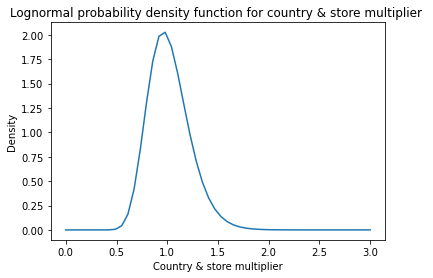

In [ ]:
# Longnormal prior for store type
store_prior = sts.lognorm(s=0.2, scale=np.exp(0))
x = np.linspace(0, 3, 50)
plt.plot(x, store_prior.pdf(x))
plt.title("Lognormal probability density function for country & store multiplier ")
plt.xlabel('Country & store multiplier')
plt.ylabel('Density')
plt.show()

#### Likelihood:
- I will use truncated $Normal$ distribution, considering its continuous positive support. 
- The center of such normal distribution will be at point of multiplication of all previous mentioned variables, specifically $\mu = M_{c_k} \times M_{s_n} \times P_i$.  
- Normal distribution can capture price’s fluctuation due to randomness which was not accounted for by multiplicators or base price outlined above.
- The standard deviation of such normal distribution should be  interpreted as a random variation in the price data and is independent of other parameters. Hence, we will assume that $\sigma_p = N(0,0.2)$. Such $\sigma_p$ can be both positive and negative.

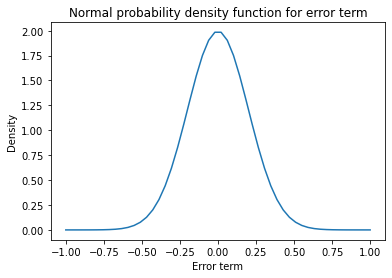

In [ ]:
# Normal prior for variance in final price
var_price = sts.norm(0, 0.2)
x = np.linspace(-1, 1, 50)
plt.plot(x, var_price.pdf(x))
plt.title("Normal probability density function for error term")
plt.xlabel("Error term")
plt.ylabel("Density")
plt.show()


### 2.1. Setting up the model in PyStan

In [ ]:
stan_code= """
// The data block contains all known quantities - typically the observed data and any constant hyperparameters.
data {
    // HYPERPARAMETERS: 
    // --for base price:--
    real<lower=0> loc;   
    real<lower=0> scale;   
    
    // --for store multiplier:--
    real<lower=0> alpha_store;      // lowered at 0 to truncate it.
    real<lower=0> beta_store;   
    
    // --for country multiplier:--
    real<lower=0> alpha_country;    // lowered at 0 to truncate it.
    real<lower=0> beta_country;   
    
    // DATA:
    int<lower=1> num_products;      // number of columns in the dataset. 
    int<lower=1> num_obs;           // len(data); number of row in the datase
    int<lower=1> num_stores;        // number of stores
    int<lower = 1> num_countries;     // countries (7)
    // vector data, indices
    int<lower=1> countries[num_obs]; // for countries
    int<lower=1> stores[num_obs];    // for stores
    int<lower=1> products[num_obs];  // products ids
    real prices[num_obs];    // prices for each observations
    // for normal dist. variance
    real loc_var; 
    real scale_var;
}


// The parameters block contains all unknown quantities - typically the parameters of the model. 
parameters {
    real<lower=0> base_p[num_products];  // manifests unknown price
    real<lower=0> store_m[num_stores];   // manifests unknown multiplier for store
    real<lower=0> country_m[num_countries];   // manifests unknown multiplier for country
    real<lower=0> vari;            
}


// The model block contains all probability distributions in the model.
model {
    // BASE PRICE PRIOR MODELING
    for (i in 1:num_products) {
        base_p[i] ~ cauchy(loc, scale);  
        
    }
    // MULTIPLIER: STORE TYPE PRIOR MODELING
    for (i in 1:num_stores) {
        store_m[i] ~ lognormal(alpha_store, beta_store);
        
    }
    // MULTIPLIER: COUNTRY TYPE PRIOR MODELING
    for (i in 1:num_countries) {
        country_m[i] ~ lognormal(alpha_country, beta_country);
    }
    // VARIANCE FOR NORMAL LIKELIHOOD MODELING
    vari ~ normal(loc_var, scale_var);
    
    // LIKELIHOOD:
    for (i in 1:num_obs) {
                    prices[i] ~ normal(base_p[products[i]]*\
                            store_m[stores[i]]*\
                            country_m[countries[i]], \
                            vari);  
    }                                        // truncated at 0 because of lowering specification in data block

}

"""

In [ ]:
stan_model = pystan.StanModel(model_code = stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7587bc19a945ad13beaf544748d2d78 NOW.


## 3. Running the model on our data.


In [ ]:
countries_model = pyStan_data['country'].tolist()
stores_model = pyStan_data['store-type'].tolist()
products_model = pyStan_data['product'].tolist()
prices_model = pyStan_data['price'].tolist()

In [ ]:
data_model = {
    'loc': 0,
    'scale': 10 ,
    
    'alpha_store': 0 ,
    'beta_store': 0.2,
    
    'alpha_country': 0,
    'beta_country':0.2 ,
    
    'num_products': 10,
    'num_obs': pyStan_data.shape[0],
    'num_stores': 3,
    'num_countries': 7,
    
    'countries': countries_model,
    'stores': stores_model , 
    'products':products_model,
    'prices':  prices_model, 
    
    'loc_var': 0,
    'scale_var':0.2 
}

RES = stan_model.sampling(data = data_model)

## 4. Answering the questions


In [ ]:
samples = RES.extract()

In [ ]:
print(RES)

Inference for Stan model: anon_model_f7587bc19a945ad13beaf544748d2d78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_p[1]      4.54    0.03   0.61   3.43   4.13   4.52    4.9   5.83    477   1.02
base_p[2]      2.14    0.01   0.34   1.53   1.91   2.13   2.36   2.86    590   1.01
base_p[3]      5.58    0.03   0.74   4.25   5.09   5.54   6.03   7.13    467   1.02
base_p[4]       2.0    0.01   0.32   1.45   1.79   1.98    2.2    2.7    613   1.01
base_p[5]      1.77    0.01    0.3   1.25   1.56   1.75   1.95   2.43    690   1.01
base_p[6]      4.82    0.03   0.65   3.63   4.39   4.78   5.21   6.15    460   1.02
base_p[7]      1.48  9.9e-3   0.27   0.98   1.29   1.46   1.65   2.04    774   1.01
base_p[8]      11.1    0.07   1.44    8.5  10.16  11.02  11.96  14.07    428   1.02
base_p[9]      0.34  4.2e-3   0.19   0.03   0.19   0.32

In [ ]:
print(samples['vari'][1+3+5])

2.4592442194421866


### What is the base price for each product?

In [ ]:
df_final_prices = pd.DataFrame(columns=['Product','Country','Store-type','Price'])

In [ ]:
for i in range(len(list(product_df['product']))):
    for j in range(len(list(store_df['store-type']))):
        for k in range(len(list(country_df['country']))):
            productT = list(product_df['product'])[i]
            storeT = list(store_df['store-type'])[j]
            countryT = list(country_df['country'])[k]
            
            #print(f'The average expected price for [{productT}] in [{storeT}] store in [{countryT}] is:' )
            base_p_i = samples['base_p'][:,i]
            country_k = samples['country_m'][:,k]
            store_j = samples['store_m'][:,j]
           # var = 2.46
 
            #final_p = sts.norm.rvs (loc = np.mean(base_p_i*country_k*store_j), scale = var, size =1)
            #print(np.mean(base_p_i*country_k*store_j))
            df_final_prices= df_final_prices.append({'Product': productT
                                    ,'Country': countryT,
                                    'Store-type':storeT,
                                    'Price': round(np.mean(base_p_i*country_k*store_j), 2)}, ignore_index = True)
   

In [ ]:
df_final_prices 
# these prices are not too accurate since they dont have variance included. Sorry for this.
# I could not sample _var_. Would apprecciate feedback.

,Product,Country,Store-type,Price
0,apple,Germany,Mid-range,4.15
1,apple,Guatemala,Mid-range,3.39
2,apple,Morocco,Mid-range,2.89
3,apple,South Korea,Mid-range,5.46
4,apple,UK,Mid-range,3.92
...,...,...,...,...
205,chicken,Morocco,Budget (cheap),5.72
206,chicken,South Korea,Budget (cheap),10.80
207,chicken,UK,Budget (cheap),7.75
208,chicken,USA,Budget (cheap),9.09


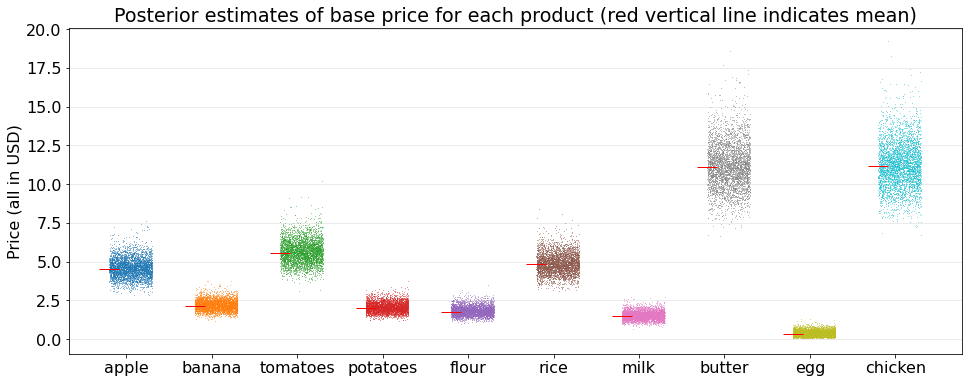

In [ ]:
plt.figure(figsize=(16,6))
for i in range(len(list(product_df['product']))):
    plt.plot(sts.uniform.rvs(loc=i+1-0.2, scale=0.5, size=4000), samples['base_p'][:,i], ',', alpha=0.5)
    plt.plot(i+1-0.2, np.mean( samples['base_p'][:,i]), markersize = 20, color = 'red', marker ='_')
plt.title("Posterior estimates of base price for each product (red vertical line indicates mean)")
plt.ylabel("Price (all in USD)")
plt.xticks([1,2,3,4,5,6,7,8,9,10],list(product_df['product']))
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

In [ ]:
count = 0
to_plot_hists = []
while count < 10: 
    to_plot_hists.append(samples['base_p'][:, count])
    count += 1

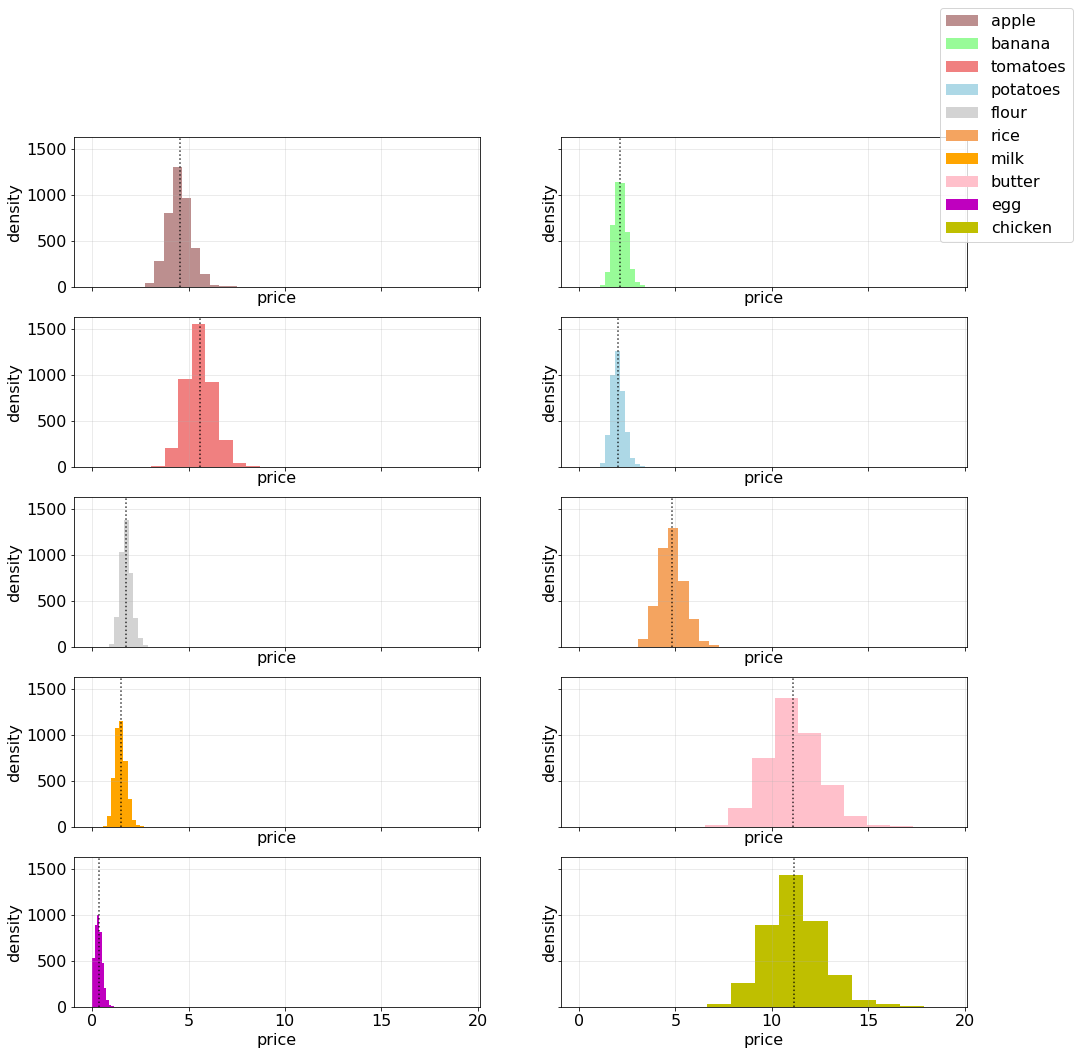

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2,figsize=(16,16),sharex=True,sharey=True)

count = 0
colors = ['rosybrown','palegreen','lightcoral', 'lightblue', 'lightgrey', 'sandybrown', 'orange', 'pink', 'm', 'y']
for row in range(5):
    for col in range(2):
        ax[row,col].hist(to_plot_hists[count],label=list(product_df["product"])[count], color = colors[count])
        ax[row,col].grid(alpha = 0.3)
        ax[row, col].axvline(x = np.mean(to_plot_hists[count]), color = 'black', linestyle = ":", alpha = 0.8)
        count+=1
        
       
fig.legend()
for axs in ax.flat:
    axs.set(xlabel='price', ylabel='density')
plt.show()
  

### What is the geographical location multiplier?

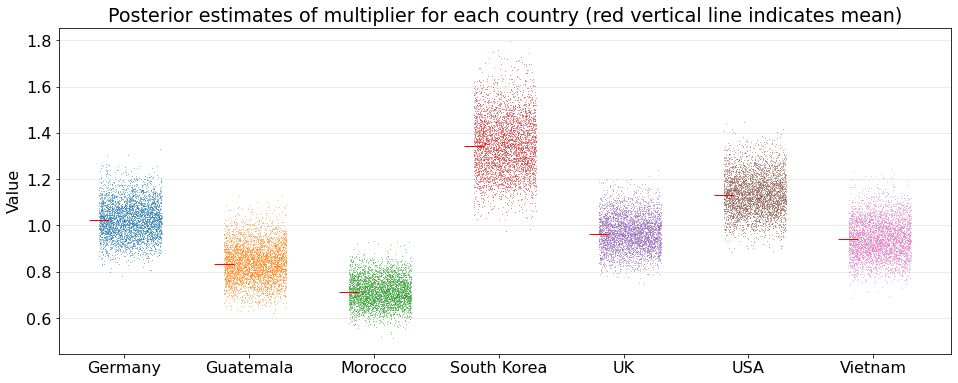

In [ ]:
plt.figure(figsize=(16,6))
for i in range(len(list(country_df['country']))):
    plt.plot(sts.uniform.rvs(loc=i+1-0.2, scale=0.5, size=4000), samples['country_m'][:,i], ',', alpha=0.5)
    plt.plot(i+1-0.2, np.mean( samples['country_m'][:,i]), markersize = 20, color = 'red', marker ='_')
plt.title("Posterior estimates of multiplier for each country (red vertical line indicates mean)")
plt.ylabel("Value")
plt.xticks([1,2,3,4,5,6,7],list(country_df['country']))
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

### What is store brand multiplier?

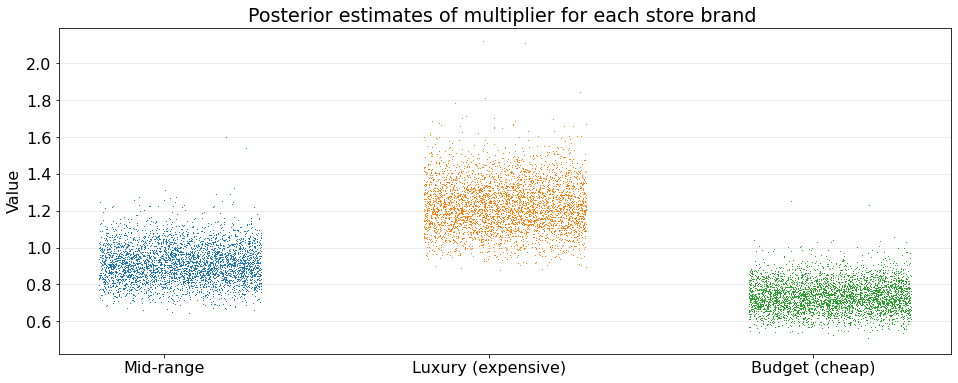

In [ ]:
plt.figure(figsize=(16,6))
for i in range(len(list(store_df['store-type']))):
    plt.plot(sts.uniform.rvs(loc=i+1-0.2, scale=0.5, size=4000), samples['store_m'][:,i], ',', alpha=1)
   
plt.title("Posterior estimates of multiplier for each store brand ")
plt.ylabel("Value")
plt.xticks([1,2,3],list(store_df['store-type']))
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

In [ ]:
# which type of mutliplier has bigger effect?
multiplier_mean = {}
for i in range(len(list(country_df['country']))):
    multiplier_mean[list(country_df['country'])[i]] = np.mean(samples['country_m'][:,i])

In [ ]:
np.mean(list(multiplier_mean.values()))

0.9928216905318995

In [ ]:
multiplier_m = {}
for i in range(len(list(store_df['store-type']))):
    multiplier_m[list(store_df['store-type'])[i]] = np.mean(samples['store_m'][:,i])

In [ ]:
np.mean(list(multiplier_m.values()))

0.9541842998078924

## Correlation between rental prices and country multiplier

In [ ]:
font = {'size'   : 16}

plt.rc('font', **font)

In [ ]:
print(multiplier_mean)

{'Germany': 1.022528828609616, 'Guatemala': 0.8354326634313156, 'Morocco': 0.7117148179669404, 'South Korea': 1.3434690848955657, 'UK': 0.9650137780709831, 'USA': 1.130804560307871, 'Vietnam': 0.9407881004410054}


In [ ]:
df.groupby('country')['ave_rental_price_m2'].mean().values

array([16.70860454,  6.63      , 19.25      ,  6.66343   , 48.7575    ,
       32.39214286,  2.66703933])

In [ ]:
print(y)

[14.040844155454545, 51.0, 175.0, 7487.0, 36.9375, 32.166875000000005, 11.333333333333334]


slope is: -2.586369130496481
intercept is: 21.577620048974335


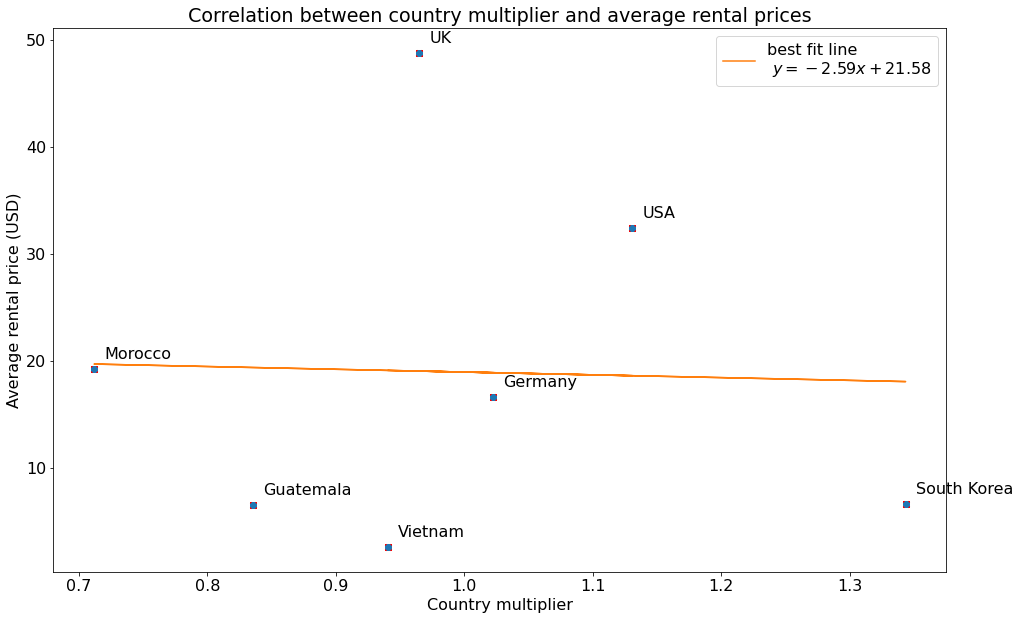

In [ ]:
# filling the best fil line: 

x = list(multiplier_mean.values())
y = list(df.groupby('country')['ave_rental_price_m2'].mean().values)

fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(x, y)
countries = list(multiplier_mean.keys())

for i, txt in enumerate(countries):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

m, b = np.polyfit(x, y, 1) #m = slope b = intercept
print("slope is:", m)
print('intercept is:', b)

plt.plot(x, y, 'o')
plt.plot(x, [m*each_x + b for each_x in x], label = f'best fit line \n $y = {round(m,2)} x +{round(b,2)}$')
plt.xlabel('Country multiplier')
plt.ylabel('Average rental price (USD)')
plt.title('Correlation between country multiplier and average rental prices')
plt.legend()